In [1]:
import torch
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
from sklearn import preprocessing
import torch.nn as nn
import functorch
import matplotlib.gridspec as gridspec
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

## Question:4
[2 marks] Write the Random walk Metropolis Hastings algorithms from scratch. Take 1000 samples using below given log probs and compare the mean and covariance matrix with hamiltorch’s standard HMC and emcee’s Metropolis Hastings implementation. Use 500 samples as the burn/warm up samples. Also check the relation between acceptance ratio and the sigma of the proposal distribution in your from scratch implementation. Use the log likelihood function given below.

In [2]:
import torch.distributions as D
def log_ll(omega):
#     omega = torch.tensor(omega)
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

In [3]:
#TODO: Compare the step size with acceptance ratio

num_samples = 1000
step_size_list = [0.05]
# uni_dist

for step_size in step_size_list:
    init_dist = D.MultivariateNormal(torch.zeros(2), step_size*torch.eye(2))
    init_sample = init_dist.sample()
    mc_samples = [init_sample.detach().numpy()]
    acc_cnt = 0
    for step_itr in range(num_samples):
        next_sample = torch.tensor(mc_samples[-1]) + init_dist.sample()
        move_crit = log_ll(next_sample) - log_ll(torch.tensor(mc_samples[-1]))
#         print(move_crit,next_sample,mc_samples[-1])
        if move_crit > torch.log(torch.rand(1)):
            mc_samples.append(next_sample.detach().numpy())
            acc_cnt +=1
        else:
            mc_samples.append(mc_samples[-1])

In [4]:
acceptance_ratio = acc_cnt/1000
acceptance_ratio

0.804

In [ ]:
filt_samples = np.asarray(mc_samples)[500:,:]
plt.scatter(filt_samples[:,0],filt_samples[:,1])

In [ ]:
torch.mean(torch.tensor(filt_samples),0), torch.cov(torch.tensor(filt_samples).T)

In [ ]:
# HMC
import hamiltorch
hamiltorch.set_random_seed(123)
params_init = torch.zeros(2)
L = 5
params_hmc = hamiltorch.sample(log_prob_func=log_ll, params_init=params_init, num_samples=num_samples,
                               step_size=step_size_list[0], num_steps_per_sample=L)

In [ ]:
out = torch.stack(params_hmc).detach().numpy()

In [ ]:
plt.scatter(out[500:,0],out[500:,1])

In [ ]:
torch.mean(torch.stack(params_hmc),0), torch.cov(torch.stack(params_hmc).T)

In [ ]:
# EMCEE implementation

In [ ]:
np.random.seed(93284)
init = np.random.randn(3, 2)
nwalkers, ndim = init.shape

def log_ll_emcee(omega):
    omega = torch.tensor(omega)
    mean = torch.tensor([0., 0.])
    stddev = torch.tensor([0.5, 1.])
    return D.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_ll_emcee,
    moves=[
        (emcee.moves.GaussianMove(step_size*torch.eye(2).detach().numpy()), 1.0)
    ],
)
sampler.run_mcmc(init, 1000)

In [ ]:
sampled_obs = sampler.get_chain()[500:, 0, :]

In [ ]:
plt.scatter(sampled_obs[:,0],sampled_obs[:,1])

In [ ]:
torch.mean(torch.tensor(sampled_obs),0), torch.cov(torch.tensor(sampled_obs).T)

In [ ]:
sampler.acceptance_fraction

## Question 3 : 

In [5]:
device

device(type='cuda')

In [6]:
from astra.torch.data import load_mnist
ds=load_mnist()
ds.data.shape

/home/rishabh.mondal/miniconda3/envs/torch_env/lib/python3.11/site-packages/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


torch.Size([70000, 28, 28])

In [7]:
# Read 1000 images from ds xarray dataset into PyTorch tensors
# print(ds['img'])
imgs = ds.data[:1000,:,:]

In [8]:
ds.targets == 5

tensor([ True, False, False,  ..., False,  True, False])

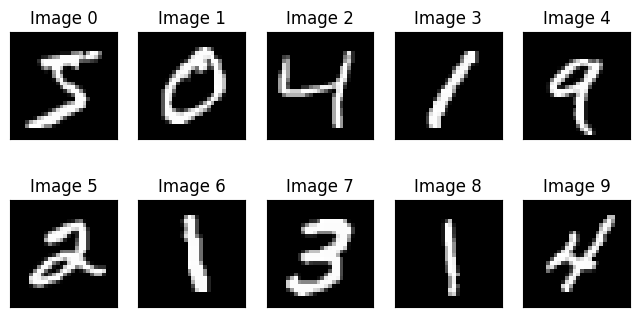

In [9]:
# Plot the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(imgs[i].view(28, 28).cpu().numpy(), cmap='gray')
    ax.set_title(f'Image {i}')
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
# Create a coordinate dataset from the image
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height* width, 2) and torch.tensor containing the (num_channels)
    """
    
    num_channels=1
    height, width = img.shape
    scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
    img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)



    # Create a 2D grid of (x,y) coordinates
    x_coords = torch.arange(width).repeat(height, 1)
    y_coords = torch.arange(height).repeat(width, 1).t()
    x_coords = x_coords.reshape(-1)
    y_coords = y_coords.reshape(-1)
    
    # Combine the x and y coordinates into a single tensor
    X = torch.stack([x_coords, y_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)
#     print(type(X))
    # Create a tensor containing the image pixel values
    Y = torch.tensor(img_scaled.reshape(-1, 1)).float().to(device) # Check without .flatten()
    return X, Y

In [11]:
# X,Y = create_coordinate_map(imgs[0])

# # MinMaxScaler from -1 to 1
# scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())

# # Scale the X coordinates
# X_scaled = scaler_X.transform(X.cpu())

# # Move the scaled X coordinates to the GPU
# X_scaled = torch.tensor(X_scaled).to(device)

# # Set to dtype float32
# X_scaled = X_scaled.float()
# # num_channels, height, width = imgs[0].shape
# # img = imgs[0]
# X_scaled,Y

In [12]:
# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

s = 128

class NN(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale, 
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)
        
    def __init__(self, activation=torch.sin, n_out=1, activation_scale=1.0):
        super().__init__()
        self.activation = activation    
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(2, s)
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)

In [13]:
class HyperNet(nn.Module):
    def __init__(self, activation=torch.sin, n_out=50049):
        super().__init__()
        self.activation = activation
        self.fc1 = nn.Linear(3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_out)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [14]:
hp = HyperNet().to(device)

In [15]:
try:
    from tabulate import tabulate
except:
    %pip install tabulate
    from tabulate import tabulate

model = NN(activation=torch.sin, n_out=1, activation_scale=30.0).to(device)

table_data = []

total_params = 0
start = 0
start_end_mapping = {}
for name, param in model.named_parameters():
    param_count = torch.prod(torch.tensor(param.shape)).item()
    total_params += param_count
    end = total_params
    table_data.append([name, param.shape, param_count, start, end])
    start_end_mapping[name] = (start, end)
    start = end

print(tabulate(table_data, headers=["Layer Name", "Shape", "Parameter Count", "Start Index", "End Index"]))
print(f"Total number of parameters: {total_params}")

Layer Name    Shape                     Parameter Count    Start Index    End Index
------------  ----------------------  -----------------  -------------  -----------
fc1.weight    torch.Size([128, 2])                  256              0          256
fc1.bias      torch.Size([128])                     128            256          384
fc2.weight    torch.Size([128, 128])              16384            384        16768
fc2.bias      torch.Size([128])                     128          16768        16896
fc3.weight    torch.Size([128, 128])              16384          16896        33280
fc3.bias      torch.Size([128])                     128          33280        33408
fc4.weight    torch.Size([128, 128])              16384          33408        49792
fc4.bias      torch.Size([128])                     128          49792        49920
fc5.weight    torch.Size([1, 128])                  128          49920        50048
fc5.bias      torch.Size([1])                         1          50048      

In [16]:
from astra.torch.utils import ravel_pytree
flat_weights, unravel_fn = ravel_pytree(dict(model.named_parameters()))



In [17]:
def train(hypernet,full_net, lr, X, Y,fullX, epochs,context_size, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(hypernet.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = full_net(X,Y,fullX,context_size)
        
#         print(outputs.shape, Y.flatten().shape)
        loss = criterion(outputs, Y.flatten())
        loss.backward()
#         for param in hypernet.parameters():
#             print(param.name, param.data)
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()



In [18]:
def hypernet_with_target(X,Y,fullX,context_size):
    # Concatenate x_c and y_c to form the context
    context = torch.cat([X[:context_size], Y[:context_size].view(-1, 1)], dim=1)
#     print(context)
    out_hp = hp(context.to(device))
    weights_flattened  = out_hp.mean(dim=0)
    target = unravel_fn(weights_flattened)
#     print(model.state_dict(),target)
#     model.load_state_dict(target)
#     y_pred = model(X.to(device)).flatten()
#     target_state_dict=model.state_dict()
#     for param_key in target_state_dict:
#         target_state_dict[param_key] = target[param_key]
#     model.load_state_dict(target_state_dict)

#     target_state_dict = model.state_dict()
#     target_state_dict.update(target)
#     model.load_state_dict(target_state_dict)
#     y_pred = model(X.to(device)).ravel()
#     print(target_state_dict)
#     print(target)
#     print(params)
#     fmodel, params = functorch.make_functional(model)
#     y_pred = fmodel(params, X.to(device)).ravel()
    
    y_pred = torch.func.functional_call(model, target, fullX.to(device)).ravel()
    return y_pred

In [19]:
num_tasks = 1

for task in range(num_tasks):
    X,Y = create_coordinate_map(imgs[task])

    # MinMaxScaler from -1 to 1
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())

    # Scale the X coordinates
    X_scaled = scaler_X.transform(X.cpu())

    # Move the scaled X coordinates to the GPU
    X_scaled = torch.tensor(X_scaled).to(device)

    # Set to dtype float32
    X_scaled = X_scaled.float()
    
    # shuffled index
    sh_index = torch.randperm(X_scaled.shape[0])

    # Shuffle the dataset
    X_sh = X_scaled[sh_index]
    Y_sh = Y[sh_index]
    
    print(f"Training started for task: {task}")
    # change fun hypernet to have context variable based on %
    train(hypernet=hp,full_net = hypernet_with_target, lr=3e-6, X=X_sh, Y=Y_sh,fullX = X_scaled, 
          epochs=10000,context_size=X_scaled.shape[0])
    print(f"Training completed for task: {task}")

Training started for task: 0
Epoch 0 loss: 1.020869


Epoch 100 loss: 0.810974
Epoch 200 loss: 0.653007
Epoch 300 loss: 0.479888
Epoch 400 loss: 0.389594
Epoch 500 loss: 0.292179
Epoch 600 loss: 0.242797
Epoch 700 loss: 0.213664
Epoch 800 loss: 0.193401
Epoch 900 loss: 0.152974
Epoch 1000 loss: 0.142381
Epoch 1100 loss: 0.134061
Epoch 1200 loss: 0.119706
Epoch 1300 loss: 0.111907
Epoch 1400 loss: 0.102431
Epoch 1500 loss: 0.105948
Epoch 1600 loss: 0.101259
Epoch 1700 loss: 0.100893
Epoch 1800 loss: 0.100086
Epoch 1900 loss: 0.098540
Epoch 2000 loss: 0.098842
Epoch 2100 loss: 0.097479
Epoch 2200 loss: 0.097687
Epoch 2300 loss: 0.097608
Epoch 2400 loss: 0.098062
Epoch 2500 loss: 0.097595
Epoch 2600 loss: 0.098142
Epoch 2700 loss: 0.097513
Epoch 2800 loss: 0.097628
Epoch 2900 loss: 0.097510
Epoch 3000 loss: 0.097678
Epoch 3100 loss: 0.098095
Epoch 3200 loss: 0.097338
Epoch 3300 loss: 0.097280
Epoch 3400 loss: 0.097612
Epoch 3500 loss: 0.097566
Epoch 3600 loss: 0.097196
Epoch 3700 loss: 0.097373
Epoch 3800 loss: 0.097640
Epoch 3900 loss: 0.09

In [20]:
# def hypernet_for_test(X,Y,fullX,context_size):
#     # Concatenate x_c and y_c to form the context
#     context = torch.cat([X[:context_size], Y[:context_size].view(-1, 1)], dim=1)
# #     print(context)
#     out_hp = hp(context.to(device))
#     weights_flattened  = out_hp.mean(dim=0)
#     target = unravel_fn(weights_flattened)
# #     print(model.state_dict(),target)
# #     model.load_state_dict(target)
# #     y_pred = model(X.to(device)).flatten()
# #     target_state_dict=model.state_dict()
# #     for param_key in target_state_dict:
# #         target_state_dict[param_key] = target[param_key]
# #     model.load_state_dict(target_state_dict)

# #     target_state_dict = model.state_dict()
# #     target_state_dict.update(target)
# #     model.load_state_dict(target_state_dict)
# #     y_pred = model(X.to(device)).ravel()
# #     print(target_state_dict)
# #     print(target)
# #     print(params)
# #     fmodel, params = functorch.make_functional(model)
# #     y_pred = fmodel(params, X.to(device)).ravel()
    
#     y_pred = torch.func.functional_call(model, target, fullX.to(device)).ravel()
#     return y_pred

In [21]:
def plot_reconstructed_and_original_image(original_img, pred, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels=1
    height, width = original_img.shape
    pred = pred.reshape(height, width)
#     pred = pred.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(pred.view(28, 28).cpu().detach().numpy(),cmap='gray')
    ax0.set_title("Reconstructed Image")
    

#     ax1.imshow(original_img.cpu())#.permute(1, 2, 0))
    ax1.imshow(original_img.view(28, 28).cpu().numpy(), cmap='gray')
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()



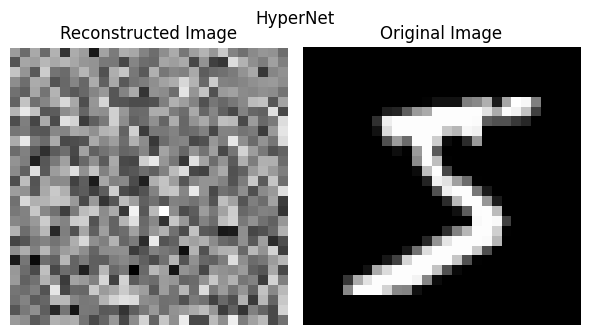

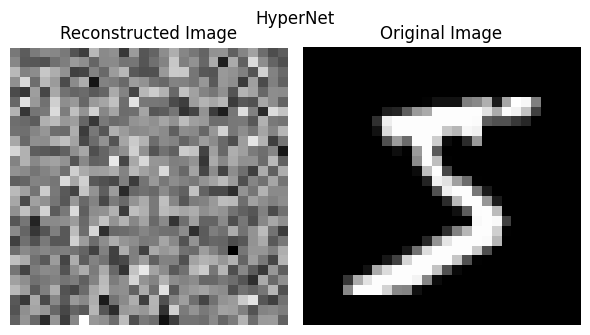

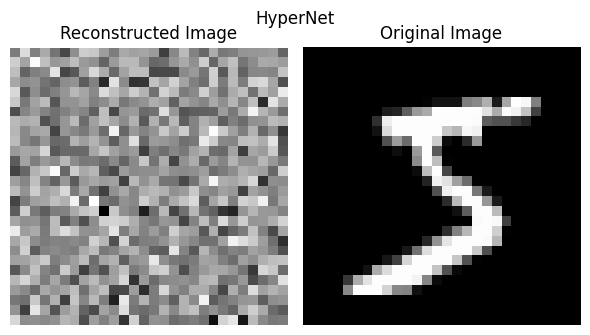

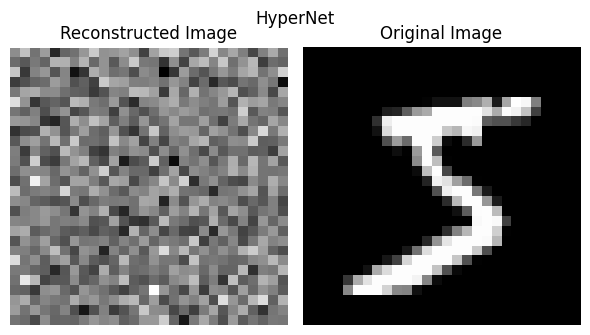

In [22]:
# Test on new tasks

num_tasks = 1
context_lengths = [1,10,100,784]
hp.eval()
model.eval()
for num_context in context_lengths:
    for task in range(num_tasks):
        # load image
        X,Y = create_coordinate_map(imgs[task])

        # MinMaxScaler from -1 to 1
        scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())

        # Scale the X coordinates
        X_scaled = scaler_X.transform(X.cpu())

        # Move the scaled X coordinates to the GPU
        X_scaled = torch.tensor(X_scaled).to(device)

        # Set to dtype float32
        X_scaled = X_scaled.float()
        
        # shuffled index
        sh_index = torch.randperm(X_scaled.shape[0])

        # Shuffle the dataset
        X_sh = X_scaled[sh_index]
        Y_sh = Y[sh_index]
        
        
        pred_img = hypernet_with_target(X_sh,Y_sh,X_scaled,num_context)
#         print(pred_img)
        plot_reconstructed_and_original_image(imgs[task], pred_img, title="HyperNet")

## Neural Process

In [ ]:
# encoder architecture

# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

s = 128

class encoder(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale, 
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)
        
    def __init__(self, activation=torch.sin, n_out=s, activation_scale=1.0):
        super().__init__()
        self.activation = activation    
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(2, s)
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)

In [ ]:
# decoder architecture

# Create a MLP with 5 hidden layers with 256 neurons each and ReLU activations.
# Input is (x, y) and output is (r, g, b) or (g) for grayscale

class decoder(nn.Module):
    def _init_siren(self, activation_scale):
        self.fc1.weight.data.uniform_(-1/self.fc1.in_features, 1/self.fc1.in_features)
        for layers in [self.fc2, self.fc3, self.fc4, self.fc5]:
            layers.weight.data.uniform_(-np.sqrt(6/self.fc2.in_features)/activation_scale, 
                                        np.sqrt(6/self.fc2.in_features)/activation_scale)
        
    def __init__(self, activation=torch.sin, n_out=1, activation_scale=1.0):
        super().__init__()
        self.activation = activation    
        self.activation_scale = activation_scale
        self.fc1 = nn.Linear(s+1, s)
        self.fc2 = nn.Linear(s, s)
        self.fc3 = nn.Linear(s, s)
        self.fc4 = nn.Linear(s, s)
        self.fc5 = nn.Linear(s, n_out) #gray scale image (1) or RGB (3)
        if self.activation == torch.sin:
            # init weights and biases for sine activation
            self._init_siren(activation_scale=self.activation_scale)

    def forward(self, x):
        x = self.activation(self.activation_scale*self.fc1(x))
        x = self.activation(self.activation_scale*self.fc2(x))
        x = self.activation(self.activation_scale*self.fc3(x))
        x = self.activation(self.activation_scale*self.fc4(x))
        return self.fc5(x)

In [ ]:
def train_np(hypernet,full_net, lr, X, Y,fullX, epochs,context_size, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    
    optimizer.zero_grad()
    representation = encoder(context)
    representation = representation.mean(dim=0, keepdim=True)
    target_repr = representation.repeat(x_t.shape[0], 1)
    joint_target_x = torch.cat([target_repr, x_t.view(-1, 1)], dim=1)
    y_pred = decoder(joint_target_x)

    l = criterion(y_pred, y_t)
    l.backward()
    optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()



In [ ]:
num_tasks = 1

for task in range(num_tasks):
    X,Y = create_coordinate_map(imgs[task])

    # MinMaxScaler from -1 to 1
    scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X.cpu())

    # Scale the X coordinates
    X_scaled = scaler_X.transform(X.cpu())

    # Move the scaled X coordinates to the GPU
    X_scaled = torch.tensor(X_scaled).to(device)

    # Set to dtype float32
    X_scaled = X_scaled.float()
    
    # shuffled index
    sh_index = torch.randperm(X_scaled.shape[0])

    # Shuffle the dataset
    X_sh = X_scaled[sh_index]
    Y_sh = Y[sh_index]
    
    print(f"Training started for task: {task}")
    # change fun hypernet to have context variable based on %
    train_np(hypernet=hp,full_net = hypernet_with_target, lr=3e-6, X=X_sh, Y=Y_sh,fullX = X_scaled, 
          epochs=2000,context_size=X_scaled.shape[0])
    print(f"Training completed for task: {task}")